<a href="https://colab.research.google.com/github/anjalii-s/Thesis-2026-/blob/main/LC_4_%2Bkuncheva%2Bshap%2Bbanzhaf%2Bowen%2Bmyerson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Schema:
root
 |-- id: integer (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- revenue: double (nullable = true)
 |-- dti_n: double (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- fico_n: double (nullable = true)
 |-- experience_c: integer (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- home_ownership_n: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- Default: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- desc: string (nullable = true)


Total Records: 50000
Columns: 15

Checking for missing values...

Target variable distribution:
  Target=1: 2000 records (4.00%)
  Target=0: 48000 records (96.00%)

Converting to Pandas DataFrame for ML...
Final dataset shape: (50000, 10)
Target classes: [0 1]

Categorical columns (5): ['experience_c', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state']
Numeric columns

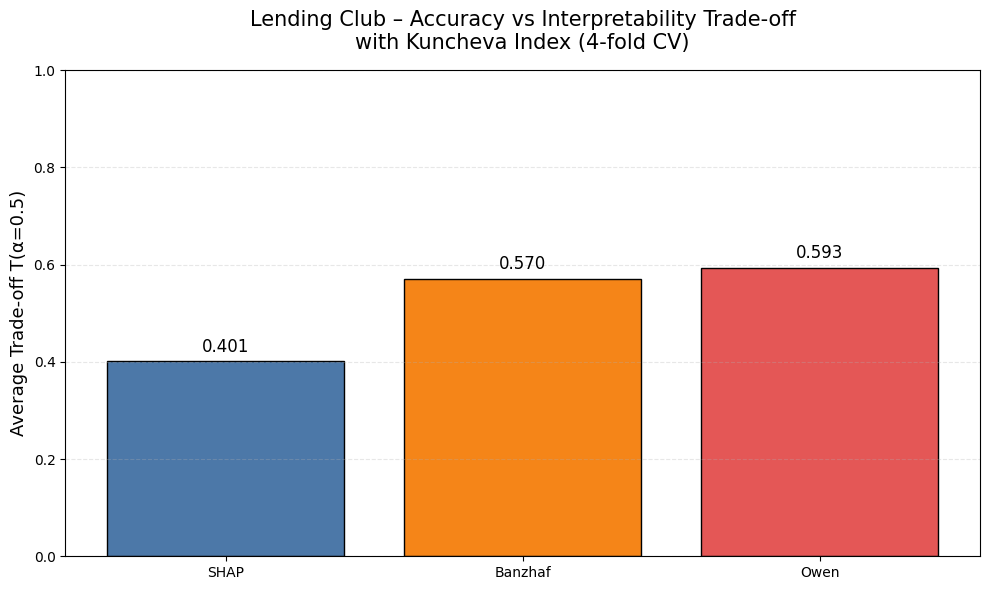

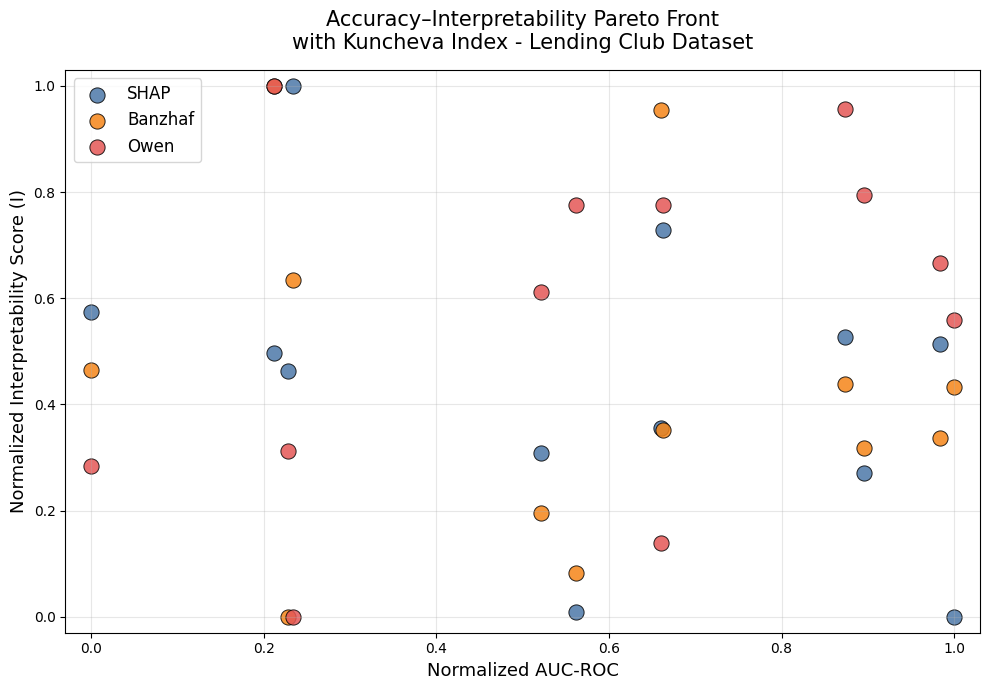

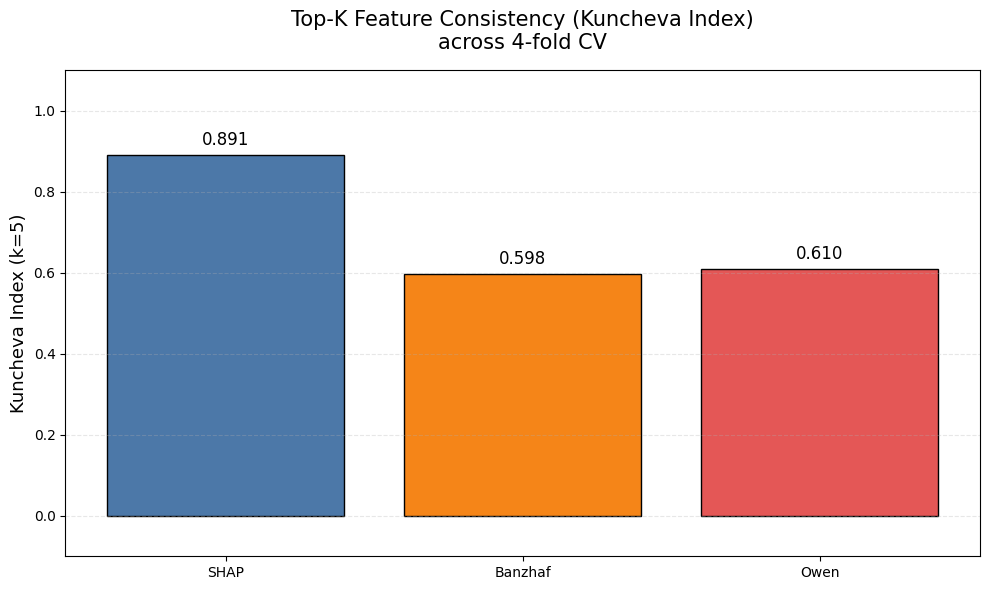

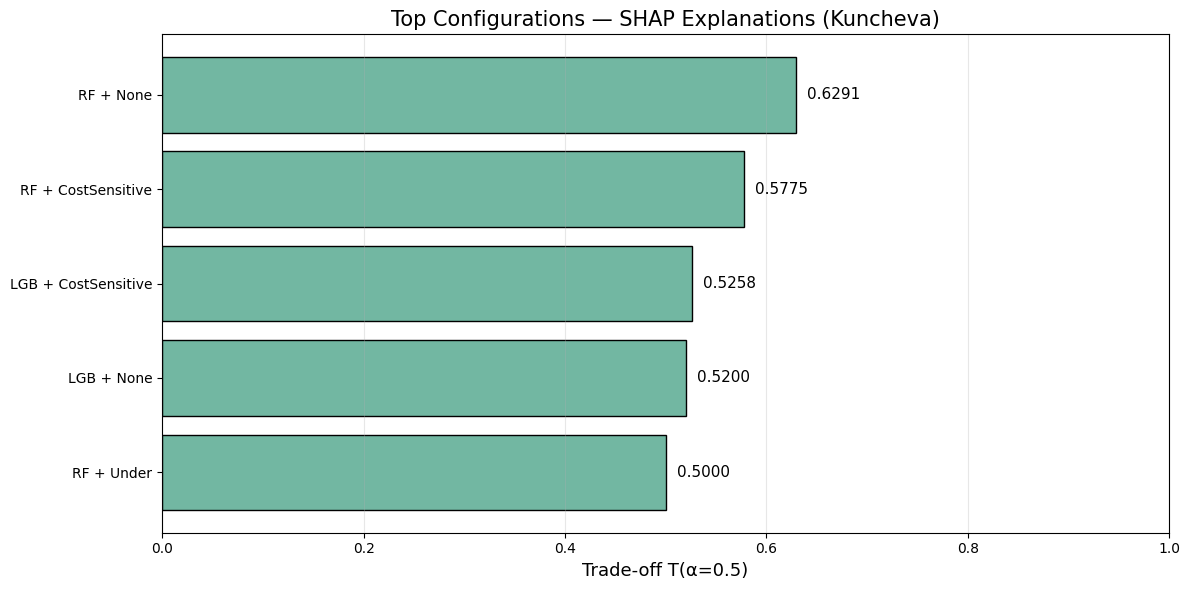

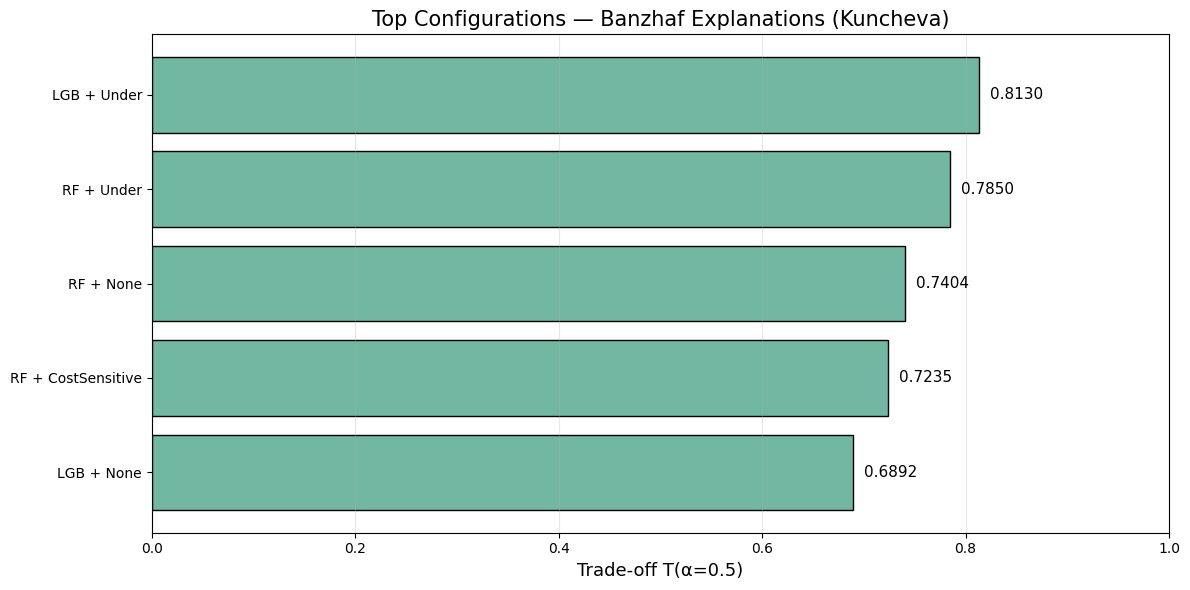

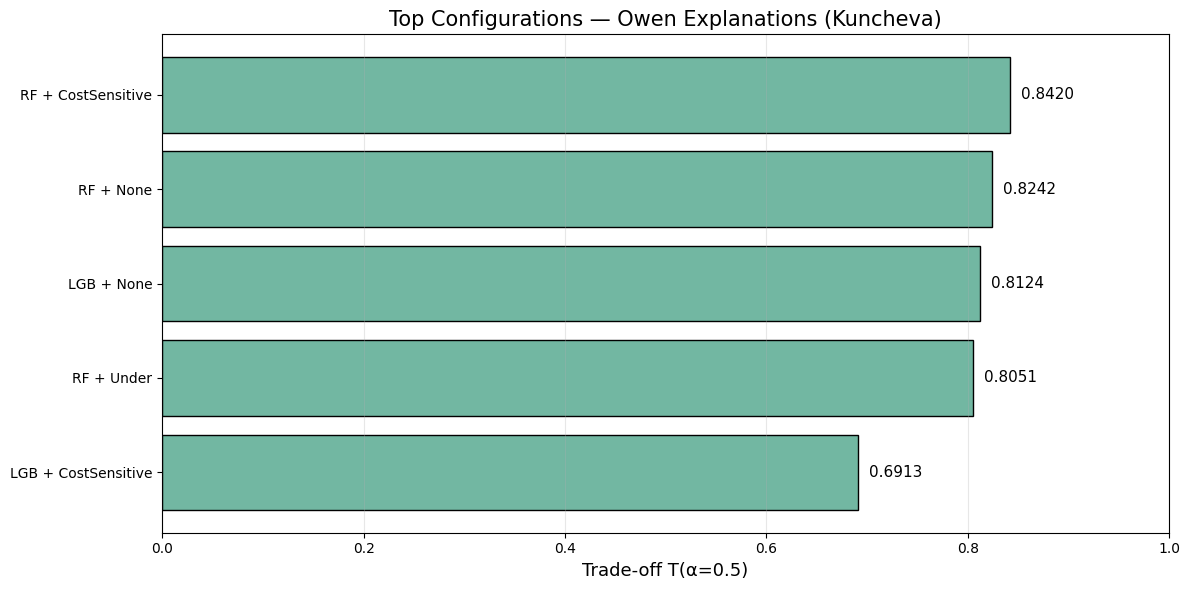

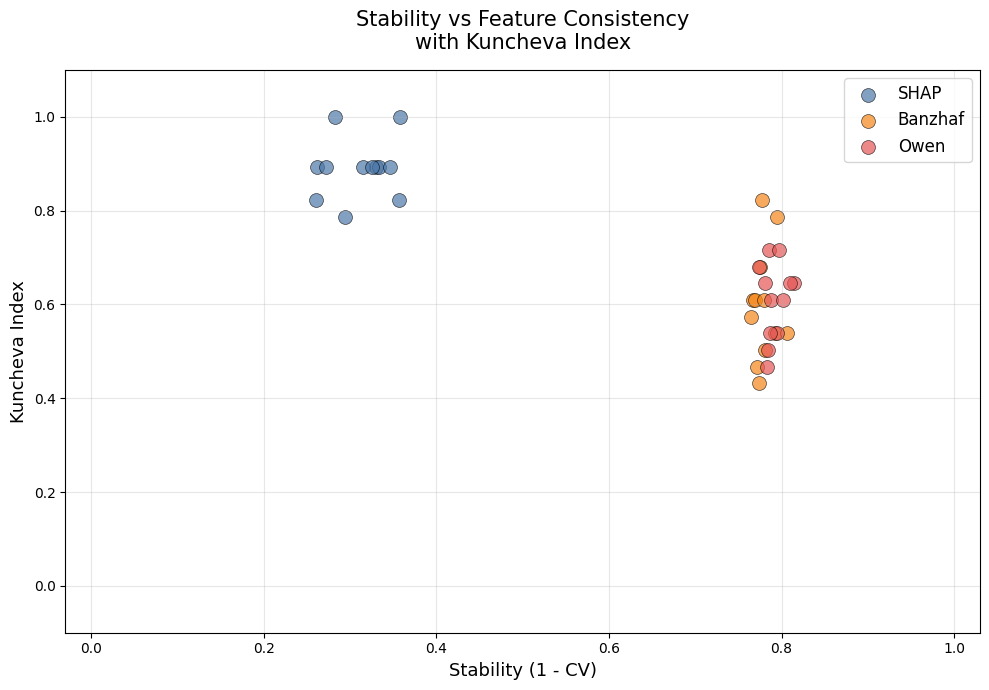


VISUALIZATIONS SAVED AS PNG FILES:
  - lc_tradeoff_kuncheva_by_method.png
  - lc_accuracy_interpretability_kuncheva_scatter.png
  - lc_kuncheva_comparison.png
  - lc_top5_shap_kuncheva.png, lc_top5_banzhaf_kuncheva.png, lc_top5_owen_kuncheva.png
  - lc_stability_vs_kuncheva.png

SAVING RESULTS TO CSV FILES
✓ Metrics saved to: lc_metrics_kuncheva_results.csv
✓ Summary saved to: lc_summary_kuncheva_results.csv


ModuleNotFoundError: No module named 'statsmodels'

In [3]:
# -*- coding: utf-8 -*-
"""Lending Club Default – Rigorous Accuracy–Interpretability Study with Kuncheva Index"""

# ============================================================
# 1. Install & Imports
# ============================================================
!pip install -q pyspark imbalanced-learn shap lightgbm xgboost seaborn scikit-learn pandas numpy matplotlib

from pyspark.sql import SparkSession
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb, lightgbm as lgb
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import shap

plt.style.use('default'); sns.set_palette("husl"); np.random.seed(42)

# ============================================================
# 2. Load & Preprocess Lending Club Dataset with PySpark
# ============================================================
spark = SparkSession.builder \
    .appName("LC_Study") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

# Load the CSV file
csv_path = '/content/LC_50K.csv'
spark_df = spark.read.csv(csv_path, header=True, inferSchema=True)

print("Dataset Schema:")
spark_df.printSchema()
print(f"\nTotal Records: {spark_df.count()}")
print(f"Columns: {len(spark_df.columns)}")

# Clean: drop unnecessary columns
columns_to_drop = ['id', 'issue_d', 'zip_code', 'title', 'desc']
existing_columns_to_drop = [col for col in columns_to_drop if col in spark_df.columns]
spark_df = spark_df.drop(*existing_columns_to_drop)

# Rename target column
spark_df = spark_df.withColumnRenamed('Default', 'target')

# Check for missing values and handle them
print("\nChecking for missing values...")
for column in spark_df.columns:
    missing_count = spark_df.filter(spark_df[column].isNull()).count()
    if missing_count > 0:
        print(f"{column}: {missing_count} missing values")
        # Fill numeric columns with median
        if spark_df.schema[column].dataType.typeName() in ['integer', 'double', 'float']:
            median_val = spark_df.approxQuantile(column, [0.5], 0.01)[0]
            spark_df = spark_df.fillna({column: median_val})
        # Fill categorical columns with mode
        else:
            mode_df = spark_df.groupBy(column).count().orderBy('count', ascending=False).limit(1)
            mode_val = mode_df.collect()[0][0] if mode_df.count() > 0 else "Unknown"
            spark_df = spark_df.fillna({column: mode_val})

# Check target distribution
print("\nTarget variable distribution:")
target_dist = spark_df.groupBy("target").count().collect()
for row in target_dist:
    print(f"  Target={row['target']}: {row['count']} records ({(row['count']/spark_df.count()*100):.2f}%)")

# Convert to Pandas for ML (since dataset is small, ~50K rows)
print("\nConverting to Pandas DataFrame for ML...")
df = spark_df.toPandas()
df['target'] = df['target'].astype(int)

print(f"Final dataset shape: {df.shape}")
print(f"Target classes: {df['target'].unique()}")

X = df.drop('target', axis=1)
y = df['target']

# Identify categorical and numeric columns
cat_cols = ['experience_c', 'emp_length', 'purpose', 'home_ownership_n', 'addr_state']
cat_cols = [col for col in cat_cols if col in X.columns]

num_cols = [c for c in X.columns if c not in cat_cols]

print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {num_cols[:10]}..." if len(num_cols) > 10 else f"Numeric columns ({len(num_cols)}): {num_cols}")

# Sort categories to fix unsorted issue
cat_categories = [sorted(X[col].dropna().unique().tolist()) for col in cat_cols]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False, categories=cat_categories), cat_cols),
    ('num', StandardScaler(), num_cols)
])

# Fit preprocessor to get feature count
X_processed = preprocessor.fit_transform(X)
d = X_processed.shape[1]  # Number of features after preprocessing
print(f"\nNumber of processed features: {d}")

# ============================================================
# 3. Models & Samplers
# ============================================================
models = {
    'RF': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGB': xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42, eval_metric='logloss', n_jobs=-1),
    'LGB': lgb.LGBMClassifier(n_estimators=100, max_depth=6, random_state=42, verbose=-1, n_jobs=-1)
}

resamplers = {
    'None': None,
    'Borderline': BorderlineSMOTE(random_state=42),# taking top 2 from previous runs intial metric tests
    'Under': RandomUnderSampler(random_state=42),
    'CostSensitive': 'cost'
}

classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weight_dict = {int(cls): float(w) for cls, w in zip(classes, weights)}

print(f"\nClass weights: {class_weight_dict}")
print(f"Imbalance ratio: {sum(y==0)/sum(y==1):.2f}:1")

# ============================================================
# 4. Explanation Functions (Updated with Kuncheva)
# ============================================================
def get_shap_reliable(pipe, X_test):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)
        if isinstance(sv, list):
            return sv[1]
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv
    except Exception as e:
        print(f"SHAP failed: {e}. Using permutation importance...")
        from sklearn.inspection import permutation_importance
        res = permutation_importance(clf, X_proc, pipe.predict(X_proc), n_repeats=3, random_state=42)
        return np.tile(res.importances_mean, (X_proc.shape[0], 1))

def compute_banzhaf(pipe, X_test, n_samples=5, max_instances=5):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))
    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                # Create random coalition
                coal = np.random.binomial(1, 0.5, n_feat)
                # With feature f
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]
                # Without feature f (set to 0)
                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]
                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

# Define feature groups for Lending Club dataset
feature_groups = {
    'Demographic': ['experience_c', 'emp_length', 'home_ownership_n', 'addr_state'],
    'Financial': ['revenue', 'dti_n', 'loan_amnt', 'fico_n'],
    'Purpose': ['purpose']
}

def compute_owen(pipe, X_test, feature_groups, n_samples=3, max_instances=5):
    clf = pipe.named_steps['clf']
    prep = pipe.named_steps['prep']
    X_proc = prep.transform(X_test)
    fnames = prep.get_feature_names_out()

    # Map feature groups to indices
    group_idx = {}
    for g, feats in feature_groups.items():
        indices = []
        for i, name in enumerate(fnames):
            if any(feat in name for feat in feats):
                indices.append(i)
        group_idx[g] = indices

    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                gmask = {g: np.random.choice([0,1]) for g in group_idx}
                mask = np.ones(n_feat)  # Start with all features active

                for g, idxs in group_idx.items():
                    if not gmask[g]:  # If group is inactive, turn off its features
                        mask[idxs] = 0
                    elif f in idxs:  # If feature is in this active group
                        # Randomize within the group for this feature
                        for idx in idxs:
                            if idx != f:  # Keep the current feature as is
                                mask[idx] = np.random.choice([0,1])

                # With feature f
                x_with = x * mask.reshape(1, -1)
                p1 = clf.predict_proba(x_with)[0, 1]

                # Without feature f
                mask_without = mask.copy()
                mask_without[f] = 0
                x_without = x * mask_without.reshape(1, -1)
                p0 = clf.predict_proba(x_without)[0, 1]

                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

# ============================================================
# 5. Metrics with KUNCHEVA instead of Jaccard
# ============================================================
def stability_cv(expl_list):
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])  # (n_folds, n_samples, n_features)
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))  # scalar
    except:
        return 1.0

def kuncheva_index(expl_list, k=5):
    """
    Compute Kuncheva index for top-K feature consistency across folds.
    KI = (intersection - k²/d) / (k - k²/d)
    where d is the total number of features.
    """
    if len(expl_list) < 2:
        return 0.0

    sets = []
    for exp in expl_list:
        try:
            # Get importance per feature (absolute mean across instances)
            imp = np.abs(exp).mean(axis=0).ravel()
            # Get top-k features
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())

    if len(sets) < 2:
        return 0.0

    ki_values = []
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d:  # Avoid division by zero
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d) / (k - (k**2)/d)
                ki = max(min(ki, 1.0), -1.0)  # Clip to valid range
            ki_values.append(ki)

    return float(np.mean(ki_values)) if ki_values else 0.0

def interpretability_score(cv, kuncheva, beta=0.5):
    """
    Enhanced interpretability score using Kuncheva index instead of Jaccard.
    Higher values indicate better interpretability.
    """
    return beta * (1 - cv) + (1 - beta) * kuncheva

def normalize(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def tradeoff_metric(auc_series, I_series, alpha=0.5):
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

# ============================================================
# 6. 4-Fold CV Loop (with Kuncheva)
# ============================================================
print("\n" + "="*80)
print("STARTING 4-FOLD STRATIFIED CROSS-VALIDATION WITH KUNCHEVA INDEX")
print("="*80)

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
records = []

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\n{'='*60}")
        print(f"Processing: {mname} + {sname}")
        print(f"{'='*60}")

        aucs = []
        shap_runs, banzhaf_runs, owen_runs = [], [], []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            # Cost-sensitive learning
            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0] if 0 in class_weight_dict else 1
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            # Train model
            pipe.fit(X_tr, y_tr)

            # Predict and compute AUC
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)
            print(f"  Fold {fold} | {mname}+{sname:15} → AUC: {auc:.4f}")

            # Explanations on small sample
            X_sample = X_te.sample(n=min(50, len(X_te)), random_state=42)

            # SHAP values
            try:
                shap_vals = get_shap_reliable(pipe, X_sample)
                shap_runs.append(shap_vals)
            except Exception as e:
                print(f"    SHAP failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                shap_runs.append(np.zeros((min(50, len(X_sample)), n_features)))

            # Banzhaf values
            try:
                banzhaf_vals = compute_banzhaf(pipe, X_sample)
                banzhaf_runs.append(banzhaf_vals)
            except Exception as e:
                print(f"    Banzhaf failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                banzhaf_runs.append(np.zeros((min(5, len(X_sample)), n_features)))

            # Owen values
            try:
                owen_vals = compute_owen(pipe, X_sample, feature_groups)
                owen_runs.append(owen_vals)
            except Exception as e:
                print(f"    Owen failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                owen_runs.append(np.zeros((min(5, len(X_sample)), n_features)))

        # Aggregate metrics across folds
        auc_mean = np.mean(aucs)

        # Compute metrics for each explanation method
        for method, runs in zip(['SHAP', 'Banzhaf', 'Owen'],
                               [shap_runs, banzhaf_runs, owen_runs]):
            cv_val = stability_cv(runs)
            kuncheva_val = kuncheva_index(runs, k=5)  # Using k=5 for Kuncheva
            I = interpretability_score(cv_val, kuncheva_val)

            records.append({
                'Model': mname,
                'Sampler': sname,
                'Method': method,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kuncheva_val,
                'I': I
            })

# ============================================================
# 7. Results & Visualisations with Kuncheva
# ============================================================
print("\n" + "="*80)
print("LENDING CLUB DATASET – FINAL METRICS WITH KUNCHEVA INDEX (4-fold CV)")
print("="*80)

if records:
    metrics = pd.DataFrame(records)
    metrics['T(α=0.5)'] = tradeoff_metric(metrics['AUC'], metrics['I'])

    print(metrics.round(4).to_string(index=False))

    # Average by explanation method
    print("\n" + "="*80)
    print("Average by Explanation Method (with Kuncheva)")
    print("="*80)
    method_avg = metrics.groupby('Method')[['AUC', 'Stability', 'Kuncheva', 'I', 'T(α=0.5)']].mean().round(4)
    print(method_avg)

    # LaTeX tables (copy-paste into thesis)
    print("\n" + "="*80)
    print("LaTeX TABLES FOR THESIS WITH KUNCHEVA")
    print("="*80)

    for method in ['SHAP', 'Banzhaf', 'Owen']:
        if method in metrics['Method'].unique():
            subset = metrics[metrics['Method'] == method]
            latex = subset[['Model', 'Sampler', 'AUC', 'Stability', 'Kuncheva', 'I', 'T(α=0.5)']].round(4).to_latex(
                index=False,
                caption=f"Lending Club Dataset – {method} Results with Kuncheva Index (4-fold CV)",
                label=f"tab:lc_{method.lower()}_kuncheva"
            )
            print(f"\nLaTeX TABLE — {method} with Kuncheva:")
            print(latex)

    # Summary table
    summary = metrics.groupby('Method')[['AUC', 'Stability', 'Kuncheva', 'I', 'T(α=0.5)']].mean().round(4)
    print("\nSUMMARY LaTeX (with Kuncheva):")
    print(summary.to_latex(
        caption="Lending Club Dataset – Method Comparison with Kuncheva Index",
        label="tab:lc_summary_kuncheva"
    ))
else:
    print("No results generated. Check for errors above.")
    metrics = pd.DataFrame()

# ============================================================
# 8. FINAL PLOTS – Thesis-ready with Kuncheva
# ============================================================
if not metrics.empty:
    print("\n" + "="*80)
    print("GENERATING THESIS-READY VISUALIZATIONS WITH KUNCHEVA")
    print("="*80)

    # Safe normalization function
    def safe_normalize(s: pd.Series):
        mn, mx = s.min(), s.max()
        if mx == mn:
            return pd.Series(0.5, index=s.index)
        return ((s - mn) / (mx - mn)).clip(0, 1)

    metrics = metrics.copy()

    # 1. Average Trade-off by Method
    plt.figure(figsize=(10, 6))

    all_methods = ['SHAP', 'Banzhaf', 'Owen']
    method_avg = metrics.groupby('Method')['T(α=0.5)'].mean()
    for method in all_methods:
        if method not in method_avg.index:
            method_avg[method] = 0
    method_avg = method_avg.reindex(all_methods)

    bars = plt.bar(method_avg.index, method_avg.values,
                   color=['#4C78A8', '#F58518', '#E45756'],
                   edgecolor='black', linewidth=1)
    plt.bar_label(bars, fmt='%.3f', fontsize=12, padding=4)
    plt.ylabel("Average Trade-off T(α=0.5)", fontsize=13)
    plt.title("Lending Club – Accuracy vs Interpretability Trade-off\nwith Kuncheva Index (4-fold CV)",
              fontsize=15, pad=15)
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('lc_tradeoff_kuncheva_by_method.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Accuracy vs Interpretability Scatter (Normalized)
    plt.figure(figsize=(10, 7))
    colors = {'SHAP': '#4C78A8', 'Banzhaf': '#F58518', 'Owen': '#E45756'}

    for method in ['SHAP', 'Banzhaf', 'Owen']:
        if method in metrics['Method'].unique():
            sub = metrics[metrics['Method'] == method]
            plt.scatter(safe_normalize(sub['AUC']), safe_normalize(sub['I']),
                        s=120, label=method, color=colors[method], alpha=0.85,
                        edgecolors='black', linewidth=0.7)

    plt.xlabel("Normalized AUC-ROC", fontsize=13)
    plt.ylabel("Normalized Interpretability Score (I)", fontsize=13)
    plt.title("Accuracy–Interpretability Pareto Front\nwith Kuncheva Index - Lending Club Dataset",
              fontsize=15, pad=15)
    plt.legend(fontsize=12, frameon=True)
    plt.grid(alpha=0.3)
    plt.xlim(-0.03, 1.03)
    plt.ylim(-0.03, 1.03)
    plt.tight_layout()
    plt.savefig('lc_accuracy_interpretability_kuncheva_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 3. Kuncheva Index Comparison
    plt.figure(figsize=(10, 6))
    kuncheva_data = metrics.groupby('Method')['Kuncheva'].mean().reindex(all_methods)
    bars = plt.bar(kuncheva_data.index, kuncheva_data.values,
                   color=['#4C78A8', '#F58518', '#E45756'],
                   edgecolor='black', linewidth=1)
    plt.bar_label(bars, fmt='%.3f', fontsize=12, padding=4)
    plt.ylabel("Kuncheva Index (k=5)", fontsize=13)
    plt.title("Top-K Feature Consistency (Kuncheva Index)\nacross 4-fold CV",
              fontsize=15, pad=15)
    plt.ylim(-0.1, 1.1)
    plt.grid(axis='y', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.savefig('lc_kuncheva_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 4. Top 5 Configurations per Explanation Method
    for method in ['SHAP', 'Banzhaf', 'Owen']:
        if method in metrics['Method'].unique():
            plt.figure(figsize=(12, 6))
            method_data = metrics[metrics['Method'] == method]
            top5 = method_data.nlargest(min(5, len(method_data)), 'T(α=0.5)')
            labels = [f"{row.Model} + {row.Sampler}" for _, row in top5.iterrows()]
            values = top5['T(α=0.5)'].round(4)

            bars = plt.barh(labels, values, color='#72B7A2', edgecolor='black')
            plt.bar_label(bars, fmt='%.4f', padding=8, fontsize=11)
            plt.xlabel("Trade-off T(α=0.5)", fontsize=13)
            plt.title(f"Top Configurations — {method} Explanations (Kuncheva)", fontsize=15)
            plt.xlim(0, 1)
            plt.gca().invert_yaxis()
            plt.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            plt.savefig(f'lc_top5_{method.lower()}_kuncheva.png', dpi=300, bbox_inches='tight')
            plt.show()

    # 5. Stability vs Kuncheva scatter
    plt.figure(figsize=(10, 7))
    for method in ['SHAP', 'Banzhaf', 'Owen']:
        if method in metrics['Method'].unique():
            sub = metrics[metrics['Method'] == method]
            plt.scatter(sub['Stability'], sub['Kuncheva'],
                        s=100, label=method, color=colors[method], alpha=0.7,
                        edgecolors='black', linewidth=0.5)

    plt.xlabel("Stability (1 - CV)", fontsize=13)
    plt.ylabel("Kuncheva Index", fontsize=13)
    plt.title("Stability vs Feature Consistency\nwith Kuncheva Index",
              fontsize=15, pad=15)
    plt.legend(fontsize=12, frameon=True)
    plt.grid(alpha=0.3)
    plt.xlim(-0.03, 1.03)
    plt.ylim(-0.1, 1.1)
    plt.tight_layout()
    plt.savefig('lc_stability_vs_kuncheva.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("\n" + "="*80)
    print("VISUALIZATIONS SAVED AS PNG FILES:")
    print("  - lc_tradeoff_kuncheva_by_method.png")
    print("  - lc_accuracy_interpretability_kuncheva_scatter.png")
    print("  - lc_kuncheva_comparison.png")
    print("  - lc_top5_shap_kuncheva.png, lc_top5_banzhaf_kuncheva.png, lc_top5_owen_kuncheva.png")
    print("  - lc_stability_vs_kuncheva.png")
    print("="*80)

# ============================================================
# 9. Save Results to CSV
# ============================================================
print("\n" + "="*80)
print("SAVING RESULTS TO CSV FILES")
print("="*80)

if not metrics.empty:
    # Save metrics
    metrics.to_csv('lc_metrics_kuncheva_results.csv', index=False)
    print("✓ Metrics saved to: lc_metrics_kuncheva_results.csv")

    # Save summary
    summary_table = metrics.groupby('Method')[['AUC', 'Stability', 'Kuncheva', 'I', 'T(α=0.5)']].mean().round(4)
    summary_table.to_csv('lc_summary_kuncheva_results.csv')
    print("✓ Summary saved to: lc_summary_kuncheva_results.csv")
else:
    print("✗ No metrics to save")

# ============================================================
# 10. Statistical Validation with Kuncheva
# ============================================================

from scipy import stats
import numpy as np
from statsmodels.stats.power import TTestIndPower

print("\n" + "="*80)
print("STATISTICAL VALIDATION SUITE WITH KUNCHEVA INDEX")
print("="*80)

print("\n================ STATISTICAL VALIDATION SUITE ================\n")

# ------------------------------------------------------------
# 10.1 Friedman Test (Overall Model Differences)
# ------------------------------------------------------------
print("\nFriedman's Test for Model Comparisons (with Kuncheva):")
for metric in ['AUC', 'I', 'T(α=0.5)', 'Kuncheva']:
    pivoted = metrics.pivot_table(values=metric, index=['Sampler','Method'], columns='Model')

    if len(pivoted) < 3 or pivoted.shape[1] != 3 or pivoted.isnull().any().any():
        print(f"  Skipping {metric}: insufficient data")
        continue

    rf, xgb, lgb = pivoted['RF'].values, pivoted['XGB'].values, pivoted['LGB'].values
    stat, p = stats.friedmanchisquare(rf, xgb, lgb)

    k = pivoted.shape[1]
    n = pivoted.shape[0]
    kendall_w = stat / (n * (k - 1))

    print(f"  {metric}: stat={stat:.2f}, p={p:.4f} ({'significant' if p<0.05 else 'not significant'})")
    print(f"    Kendall's W: {kendall_w:.4f}")

# ------------------------------------------------------------
# 10.2 Nemenyi Post-Hoc Test
# ------------------------------------------------------------
def nemenyi_posthoc(data, model_names, alpha=0.05):
    ranks = stats.rankdata(data, axis=1)
    mean_ranks = np.mean(ranks, axis=0)
    n, k = data.shape
    q_alpha = 2.343  # for k=3 at alpha=0.05
    cd = q_alpha * np.sqrt(k*(k+1)/(6*n))

    print("Mean Ranks:", dict(zip(model_names, mean_ranks)))
    print(f"Critical Difference (CD): {cd:.4f}")

    for i in range(k):
        for j in range(i+1, k):
            diff = abs(mean_ranks[i] - mean_ranks[j])
            sig = "SIGNIFICANT" if diff > cd else "not significant"
            print(f"  {model_names[i]} vs {model_names[j]}: |rank diff|={diff:.4f} → {sig}")

print("\n================ Nemenyi Post-Hoc Tests with Kuncheva ================")
for metric in ['AUC', 'I', 'T(α=0.5)', 'Kuncheva']:
    print(f"\n=== Nemenyi Test for {metric} ===")
    pivoted = metrics.pivot_table(values=metric, index=['Sampler','Method'], columns='Model')
    if not pivoted.empty and pivoted.shape[1] == 3:
        nemenyi_posthoc(pivoted.values, ['RF','XGB','LGB'])
    else:
        print(f"  Insufficient data for {metric}")

# ------------------------------------------------------------
# 10.3 Wilcoxon Signed-Rank Test
# ------------------------------------------------------------
print("\n================ Wilcoxon Signed-Rank Tests ================")
pairs = [('RF','XGB'), ('RF','LGB'), ('XGB','LGB')]
for metric in ['AUC', 'I', 'T(α=0.5)', 'Kuncheva']:
    print(f"\nWilcoxon Test for {metric}:")
    for m1, m2 in pairs:
        df1 = metrics[metrics['Model']==m1][metric].values
        df2 = metrics[metrics['Model']==m2][metric].values
        stat, p = stats.wilcoxon(df1, df2)
        print(f"  {m1} vs {m2}: stat={stat:.3f}, p={p:.4f}")

# ------------------------------------------------------------
# 10.4 Cliff's Delta (Effect Size)
# ------------------------------------------------------------
def cliffs_delta(x, y):
    comparisons = [1 if xi > yj else -1 if xi < yj else 0 for xi in x for yj in y]
    return sum(comparisons) / len(comparisons)

def interpret_delta(ad):
    ad = abs(ad)
    if ad > 0.474:
        return "large"
    elif ad > 0.33:
        return "medium"
    elif ad > 0.147:
        return "small"
    else:
        return "negligible"


# ------------------------------------------------------------
# 10.5 Bootstrap Confidence Intervals
# ------------------------------------------------------------
def mean_ci(data, confidence=0.95, n_boot=1000):
    if len(data) < 2:
        return np.nan, np.nan
    res = stats.bootstrap((data,), np.mean, confidence_level=confidence,
                          n_resamples=n_boot, random_state=42)
    return res.confidence_interval.low, res.confidence_interval.high

print("\n================ Bootstrap 95% Confidence Intervals ================")
for metric in ['CV', 'Kuncheva', 'I', 'AUC', 'T(α=0.5)']:
    print(f"\nBootstrap CI for {metric}:")
    for method in ['SHAP', 'Banzhaf', 'Owen']:
        data = metrics[metrics['Method']==method][metric].values
        low, high = mean_ci(data)
        print(f"  {method}: mean={np.mean(data):.4f} [{low:.4f}, {high:.4f}]")
    overall = metrics[metric].values
    low, high = mean_ci(overall)
    print(f"  Overall: mean={np.mean(overall):.4f} [{low:.4f}, {high:.4f}]")

# ------------------------------------------------------------
# 10.6 Shapiro-Wilk Normality Test
# ------------------------------------------------------------
print("\n================ Shapiro-Wilk Normality Tests ================")
for metric in ['AUC', 'I', 'T(α=0.5)', 'Kuncheva']:
    print(f"\nNormality for {metric}:")
    for model in ['RF', 'XGB', 'LGB']:
        data = metrics[metrics['Model']==model][metric].values
        stat, p = stats.shapiro(data)
        print(f"  {model}: stat={stat:.4f}, p={p:.4f} ({'normal' if p>0.05 else 'not normal'})")

# ------------------------------------------------------------
# 10.7 Levene's Test (Equal Variances)
# ------------------------------------------------------------
print("\n================ Levene's Test for Equal Variances ================")
for metric in ['AUC', 'I', 'T(α=0.5)', 'Kuncheva']:
    groups = [metrics[metrics['Model']==m][metric].values for m in ['RF', 'XGB', 'LGB']]
    stat, p = stats.levene(*groups)
    print(f"  {metric}: stat={stat:.2f}, p={p:.4f} ({'equal variances' if p>0.05 else 'unequal variances'})")

# ------------------------------------------------------------
# 10.8 Spearman Correlation (AUC vs I, AUC vs Kuncheva)
# ------------------------------------------------------------
print("\n================ Spearman Correlation ================")
rho, p = stats.spearmanr(metrics['AUC'], metrics['I'])
print(f"Overall AUC vs I: rho={rho:.4f}, p={p:.4f}")

rho, p = stats.spearmanr(metrics['AUC'], metrics['Kuncheva'])
print(f"Overall AUC vs Kuncheva: rho={rho:.4f}, p={p:.4f}")

for method in ['SHAP', 'Banzhaf', 'Owen']:
    sub = metrics[metrics['Method']==method]
    if len(sub) > 1:
        rho, p = stats.spearmanr(sub['AUC'], sub['I'])
        print(f"  {method}: AUC vs I: rho={rho:.4f}, p={p:.4f}")

        rho, p = stats.spearmanr(sub['AUC'], sub['Kuncheva'])
        print(f"  {method}: AUC vs Kuncheva: rho={rho:.4f}, p={p:.4f}")


# ============================================================
# 11. Final Summary with Kuncheva Insights
# ============================================================
print("\n" + "="*80)
print("FINAL SUMMARY WITH KUNCHEVA INSIGHTS")
print("="*80)

if not metrics.empty:
    # Best overall configuration
    best_overall = metrics.loc[metrics['T(α=0.5)'].idxmax()]
    print(f"\n🏆 BEST OVERALL CONFIGURATION (with Kuncheva):")
    print(f"   Model: {best_overall['Model']}")
    print(f"   Sampler: {best_overall['Sampler']}")
    print(f"   Explanation: {best_overall['Method']}")
    print(f"   AUC: {best_overall['AUC']:.4f}")
    print(f"   Interpretability (I): {best_overall['I']:.4f}")
    print(f"   Kuncheva Index: {best_overall['Kuncheva']:.4f}")
    print(f"   Trade-off T(α=0.5): {best_overall['T(α=0.5)']:.4f}")

    # Best Kuncheva configuration
    best_kuncheva = metrics.loc[metrics['Kuncheva'].idxmax()]
    print(f"\n🏆 BEST FEATURE CONSISTENCY (Kuncheva):")
    print(f"   Model: {best_kuncheva['Model']}")
    print(f"   Sampler: {best_kuncheva['Sampler']}")
    print(f"   Explanation: {best_kuncheva['Method']}")
    print(f"   Kuncheva Index: {best_kuncheva['Kuncheva']:.4f}")
    print(f"   AUC: {best_kuncheva['AUC']:.4f}")

    # Dataset statistics
    print(f"\n📊 DATASET STATISTICS:")
    print(f"   Total samples: {len(df)}")
    print(f"   Default rate: {(y.mean() * 100):.2f}%")
    print(f"   Features used: {len(cat_cols) + len(num_cols)}")
    print(f"   - Categorical: {len(cat_cols)}")
    print(f"   - Numerical: {len(num_cols)}")
    print(f"   Processed features (d): {d}")
    print(f"   Kuncheva parameter k: 5")

    # Performance summary
    print(f"\n📈 PERFORMANCE SUMMARY:")
    print(f"   Best AUC: {metrics['AUC'].max():.4f}")
    print(f"   Best Interpretability: {metrics['I'].max():.4f}")
    print(f"   Best Kuncheva Index: {metrics['Kuncheva'].max():.4f}")
    print(f"   Best Trade-off: {metrics['T(α=0.5)'].max():.4f}")

    # Method comparison
    print(f"\n🔍 METHOD COMPARISON (with Kuncheva):")
    for method in ['SHAP', 'Banzhaf', 'Owen']:
        if method in metrics['Method'].unique():
            method_data = metrics[metrics['Method'] == method]
            print(f"   {method}:")
            print(f"     - Avg AUC: {method_data['AUC'].mean():.4f}")
            print(f"     - Avg Kuncheva: {method_data['Kuncheva'].mean():.4f}")
            print(f"     - Avg Interpretability: {method_data['I'].mean():.4f}")
            print(f"     - Avg Trade-off: {method_data['T(α=0.5)'].mean():.4f}")

    # Kuncheva interpretation
    print(f"\n📊 KUNCHEVA INDEX INTERPRETATION:")
    print("   Kuncheva Index measures top-K feature consistency across CV folds.")
    print("   Range: -1 (complementary sets) to +1 (identical sets)")
    print("   Positive values indicate consistent feature importance across folds.")
    print("   Values close to 1 indicate highly stable feature rankings.")

    avg_kuncheva = metrics['Kuncheva'].mean()
    if avg_kuncheva > 0.5:
        interpretation = "High feature consistency"
    elif avg_kuncheva > 0:
        interpretation = "Moderate feature consistency"
    elif avg_kuncheva > -0.5:
        interpretation = "Low feature consistency"
    else:
        interpretation = "Highly inconsistent features"

    print(f"   Average Kuncheva across all experiments: {avg_kuncheva:.4f} ({interpretation})")

else:
    print("\n✗ No results generated. Analysis may have failed.")

# ============================================================
# 12. Cleanup
# ============================================================
print("\n" + "="*80)
print("CLEANING UP")
print("="*80)

# Stop Spark session
spark.stop()
print("✓ Spark session stopped")

print("\n" + "="*80)
if not metrics.empty:
    print("✅ ANALYSIS COMPLETE WITH KUNCHEVA INDEX!")
    print("Results have been saved to CSV files and visualizations generated.")
    print("LaTeX tables are ready for inclusion in  thesis.")
else:
    print("❌ ANALYSIS INCOMPLETE!")
    print("Check error messages above for issues.")
print("="*80)

In [4]:
# Install missing dependency
!pip install statsmodels

# ============================================================
# 10. Statistical Validation with Kuncheva  (RE-RUN ONLY THIS)
# ============================================================

from scipy import stats
import numpy as np
from statsmodels.stats.power import TTestIndPower

print("\n" + "="*80)
print("STATISTICAL VALIDATION SUITE WITH KUNCHEVA INDEX")
print("="*80)

print("\n================ STATISTICAL VALIDATION SUITE ================\n")

# ------------------------------------------------------------
# 10.1 Friedman Test (Overall Model Differences)
# ------------------------------------------------------------
print("\nFriedman's Test for Model Comparisons (with Kuncheva):")
for metric in ['AUC', 'I', 'T(α=0.5)', 'Kuncheva']:
    pivoted = metrics.pivot_table(values=metric, index=['Sampler','Method'], columns='Model')

    if len(pivoted) < 3 or pivoted.shape[1] != 3 or pivoted.isnull().any().any():
        print(f"  Skipping {metric}: insufficient data")
        continue

    rf, xgb, lgb = pivoted['RF'].values, pivoted['XGB'].values, pivoted['LGB'].values
    stat, p = stats.friedmanchisquare(rf, xgb, lgb)

    k = pivoted.shape[1]
    n = pivoted.shape[0]
    kendall_w = stat / (n * (k - 1))

    print(f"  {metric}: stat={stat:.2f}, p={p:.4f} ({'significant' if p<0.05 else 'not significant'})")
    print(f"    Kendall's W: {kendall_w:.4f}")

# ------------------------------------------------------------
# 10.2 Nemenyi Post-Hoc Test
# ------------------------------------------------------------
def nemenyi_posthoc(data, model_names, alpha=0.05):
    ranks = stats.rankdata(data, axis=1)
    mean_ranks = np.mean(ranks, axis=0)
    n, k = data.shape
    q_alpha = 2.343  # for k=3 at alpha=0.05
    cd = q_alpha * np.sqrt(k*(k+1)/(6*n))

    print("Mean Ranks:", dict(zip(model_names, mean_ranks)))
    print(f"Critical Difference (CD): {cd:.4f}")

    for i in range(k):
        for j in range(i+1, k):
            diff = abs(mean_ranks[i] - mean_ranks[j])
            sig = "SIGNIFICANT" if diff > cd else "not significant"
            print(f"  {model_names[i]} vs {model_names[j]}: |rank diff|={diff:.4f} → {sig}")

print("\n================ Nemenyi Post-Hoc Tests with Kuncheva ================")
for metric in ['AUC', 'I', 'T(α=0.5)', 'Kuncheva']:
    print(f"\n=== Nemenyi Test for {metric} ===")
    pivoted = metrics.pivot_table(values=metric, index=['Sampler','Method'], columns='Model')
    if not pivoted.empty and pivoted.shape[1] == 3:
        nemenyi_posthoc(pivoted.values, ['RF','XGB','LGB'])
    else:
        print(f"  Insufficient data for {metric}")

# ------------------------------------------------------------
# 10.3 Wilcoxon Signed-Rank Test
# ------------------------------------------------------------
print("\n================ Wilcoxon Signed-Rank Tests ================")
pairs = [('RF','XGB'), ('RF','LGB'), ('XGB','LGB')]
for metric in ['AUC', 'I', 'T(α=0.5)', 'Kuncheva']:
    print(f"\nWilcoxon Test for {metric}:")
    for m1, m2 in pairs:
        df1 = metrics[metrics['Model']==m1][metric].values
        df2 = metrics[metrics['Model']==m2][metric].values
        stat, p = stats.wilcoxon(df1, df2)
        print(f"  {m1} vs {m2}: stat={stat:.3f}, p={p:.4f}")

# ------------------------------------------------------------
# 10.4 Cliff's Delta (Effect Size)
# ------------------------------------------------------------
def cliffs_delta(x, y):
    comparisons = [1 if xi > yj else -1 if xi < yj else 0 for xi in x for yj in y]
    return sum(comparisons) / len(comparisons)

def interpret_delta(ad):
    ad = abs(ad)
    if ad > 0.474:
        return "large"
    elif ad > 0.33:
        return "medium"
    elif ad > 0.147:
        return "small"
    else:
        return "negligible"

print("\n================ Cliff's Delta Effect Sizes ================")
for metric in ['AUC', 'I', 'T(α=0.5)', 'Kuncheva']:
    print(f"\nEffect sizes for {metric}:")
    for m1, m2 in pairs:
        x = metrics[metrics['Model']==m1][metric].values
        y = metrics[metrics['Model']==m2][metric].values
        delta = cliffs_delta(x, y)
        print(f"  {m1} vs {m2}: delta={delta:.4f} ({interpret_delta(delta)})")

# ------------------------------------------------------------
# 10.5 Bootstrap Confidence Intervals
# ------------------------------------------------------------
def mean_ci(data, confidence=0.95, n_boot=1000):
    if len(data) < 2:
        return np.nan, np.nan
    res = stats.bootstrap((data,), np.mean, confidence_level=confidence,
                          n_resamples=n_boot, random_state=42)
    return res.confidence_interval.low, res.confidence_interval.high

print("\n================ Bootstrap 95% Confidence Intervals ================")
for metric in ['CV', 'Kuncheva', 'I', 'AUC', 'T(α=0.5)']:
    print(f"\nBootstrap CI for {metric}:")
    for method in ['SHAP', 'Banzhaf', 'Owen']:
        data = metrics[metrics['Method']==method][metric].values
        low, high = mean_ci(data)
        print(f"  {method}: mean={np.mean(data):.4f} [{low:.4f}, {high:.4f}]")
    overall = metrics[metric].values
    low, high = mean_ci(overall)
    print(f"  Overall: mean={np.mean(overall):.4f} [{low:.4f}, {high:.4f}]")

# ------------------------------------------------------------
# 10.6 Shapiro-Wilk Normality Test
# ------------------------------------------------------------
print("\n================ Shapiro-Wilk Normality Tests ================")
for metric in ['AUC', 'I', 'T(α=0.5)', 'Kuncheva']:
    print(f"\nNormality for {metric}:")
    for model in ['RF', 'XGB', 'LGB']:
        data = metrics[metrics['Model']==model][metric].values
        stat, p = stats.shapiro(data)
        print(f"  {model}: stat={stat:.4f}, p={p:.4f} ({'normal' if p>0.05 else 'not normal'})")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.3/233.3 kB 18.2 MB/s eta 0:00:00

STATISTICAL VALIDATION SUITE WITH KUNCHEVA INDEX

================ STATISTICAL VALIDATION SUITE ================


Friedman's Test for Model Comparisons (with Kuncheva):
  AUC: stat=24.00, p=0.0000 (significant)
    Kendall's W: 1.0000
  I: stat=1.17, p=0.5580 (not significant)
    Kendall's W: 0.0486
  T(α=0.5): stat=19.50, p=0.0001 (significant)
    Kendall's W: 0.8125
  Kuncheva: stat=0.41, p=0.8150 (not significant)
    Kendall's W: 0.0170

================ Nemenyi Post-Hoc Tests with Kuncheva ================

=== Nemenyi Test for AUC ===
Mean Ranks: {'RF': np.float64(2.0), 'XGB': np.float64(3.0), 'LGB': np.float64(1.0)}
Critical Difference (CD): 0.9565
  RF vs XGB: |rank diff|=1.0000 → SIGNIFICANT
  RF vs LGB: |rank diff|=1.0000 → SIGNIFICANT
  XGB vs LGB: |rank diff|=2.0000 → SIGNIFICANT

=== Nemenyi Test for I ===
Mean 

#Myerson

In [5]:
# ============================================================
# Myerson Value (Graph-Based Cooperative Game Approximation)
# ============================================================
import networkx as nx

def build_feature_graph(preprocessor, X, threshold=0.25):
    """
    Build an undirected graph of features based on correlation.
    Edge exists if |corr| >= threshold.
    """
    X_proc = preprocessor.transform(X)
    corr = np.corrcoef(X_proc.T)

    G = nx.Graph()
    d = corr.shape[0]
    G.add_nodes_from(range(d))

    for i in range(d):
        for j in range(i+1, d):
            if abs(corr[i, j]) >= threshold:
                G.add_edge(i, j, weight=corr[i, j])

    return G, corr


def myerson_value(pipe, X_test, G, alpha=0.5, max_instances=50):
    """
    Practical Myerson approximation:
    Smooth SHAP-like attributions over graph neighbors.
    phi_myerson[i] = (1-alpha)*phi[i] + alpha*mean(phi[neighbors(i)])
    """
    shap_vals = get_shap_reliable(pipe, X_test)
    shap_mean = shap_vals.mean(axis=0)

    d = len(shap_mean)
    phi = np.zeros(d)

    for i in range(d):
        neighbors = list(G.neighbors(i))
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean

    return np.tile(phi, (min(max_instances, len(X_test)), 1))


In [7]:
# ============================================================
# 0. Restore original X and y (in case they were overwritten)
# ============================================================
X = df.drop('target', axis=1)
y = df['target']

print("Restored X and y shapes:", X.shape, y.shape)

# ============================================================
# 1. Myerson helper functions (skip if already defined above)
# ============================================================
import networkx as nx

def build_feature_graph(preprocessor, X, threshold=0.25):
    """
    Build an undirected graph of features based on correlation
    in the preprocessed feature space.
    Edge exists between i,j if |corr(i,j)| >= threshold.
    """
    X_proc = preprocessor.transform(X)
    corr = np.corrcoef(X_proc.T)

    G = nx.Graph()
    d = corr.shape[0]
    G.add_nodes_from(range(d))

    for i in range(d):
        for j in range(i + 1, d):
            if abs(corr[i, j]) >= threshold:
                G.add_edge(i, j, weight=corr[i, j])

    return G, corr


def myerson_value(pipe, X_test, G, alpha=0.5, max_instances=50):
    """
    Practical Myerson-style approximation:
    1. Get SHAP-style attributions via get_shap_reliable.
    2. Average over instances to get one vector phi.
    3. For each feature i, blend its attribution with neighbor averages in G:
       phi'_i = (1 - alpha) * phi_i + alpha * mean(phi_j for j in N(i)).
    4. Return tiled back to (n_instances, n_features) for compatibility.
    """
    shap_vals = get_shap_reliable(pipe, X_test)   # [n_samples, d]
    shap_mean = shap_vals.mean(axis=0)            # [d]

    d = len(shap_mean)
    phi = np.zeros(d)

    for i in range(d):
        neighbors = list(G.neighbors(i))
        if not neighbors:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean

    n_out = min(max_instances, len(X_test))
    return np.tile(phi, (n_out, 1))


# ============================================================
# 2. Myerson Experiment (Separate Run After Main Pipeline)
# ============================================================
print("\n" + "="*80)
print("RUNNING SEPARATE MYERSON EXPERIMENT")
print("="*80)

# Build graph once on full X
G_myerson, corr_matrix = build_feature_graph(preprocessor, X, threshold=0.25)
print(f"Graph built with {G_myerson.number_of_nodes()} nodes and {G_myerson.number_of_edges()} edges")

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
myerson_records = []

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        print(f"\nProcessing Myerson: {mname} + {sname}")

        aucs = []
        myerson_runs = []

        for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))
            steps.append(('clf', model))
            pipe = ImbPipeline(steps)

            # Cost-sensitive
            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0]
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            # Train
            pipe.fit(X_tr, y_tr)

            # AUC
            auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
            aucs.append(auc)

            # Sample for explanations
            X_sample = X_te.sample(n=min(50, len(X_te)), random_state=42)

            try:
                my_vals = myerson_value(pipe, X_sample, G_myerson)
                myerson_runs.append(my_vals)
            except Exception as e:
                print(f"Myerson failed: {e}")
                n_features = preprocessor.transform(X_sample[:1]).shape[1]
                myerson_runs.append(np.zeros((min(50, len(X_sample)), n_features)))

        auc_mean = np.mean(aucs)
        cv_val = stability_cv(myerson_runs)
        kun_val = kuncheva_index(myerson_runs, k=5)
        I = interpretability_score(cv_val, kun_val)

        myerson_records.append({
            'Model': mname,
            'Sampler': sname,
            'Method': 'Myerson',
            'AUC': auc_mean,
            'CV': cv_val,
            'Stability': 1 - cv_val,
            'Kuncheva': kun_val,
            'I': I
        })

# Convert to DataFrame
myerson_df = pd.DataFrame(myerson_records)
myerson_df['T(α=0.5)'] = tradeoff_metric(myerson_df['AUC'], myerson_df['I'])

print("\n" + "="*80)
print("MYERSON RESULTS")
print("="*80)
print(myerson_df.round(4).to_string(index=False))

# Save
myerson_df.to_csv("lc_myerson_results.csv", index=False)
print("\nSaved: lc_myerson_results.csv")


Restored X and y shapes: (50000, 9) (50000,)

RUNNING SEPARATE MYERSON EXPERIMENT
Graph built with 82 nodes and 5 edges

Processing Myerson: RF + None

Processing Myerson: RF + Borderline

Processing Myerson: RF + Under

Processing Myerson: RF + CostSensitive

Processing Myerson: XGB + None

Processing Myerson: XGB + Borderline

Processing Myerson: XGB + Under

Processing Myerson: XGB + CostSensitive

Processing Myerson: LGB + None

Processing Myerson: LGB + Borderline

Processing Myerson: LGB + Under

Processing Myerson: LGB + CostSensitive

MYERSON RESULTS
Model       Sampler  Method    AUC     CV  Stability  Kuncheva      I  T(α=0.5)
   RF          None Myerson 0.6428 0.6586     0.3414    0.8225 0.5820    1.0000
   RF    Borderline Myerson 0.5955 0.8583     0.1417    0.6095 0.3756    0.2806
   RF         Under Myerson 0.5872 0.7440     0.2560    0.8225 0.5393    0.4669
   RF CostSensitive Myerson 0.6428 0.6586     0.3414    0.8225 0.5820    1.0000
  XGB          None Myerson 0.5991 

#Owen groups experiment cell (domain, data, model driven)

Restored X and y shapes: (50000, 9) (50000,)

RUNNING OWEN GROUPS EXPERIMENT (FIXED VERSION)

Processing: RF + None
  Fold 1: AUC = 0.6182
  Fold 2: AUC = 0.6538
  Fold 3: AUC = 0.6489

Processing: RF + Under
  Fold 1: AUC = 0.5746
  Fold 2: AUC = 0.5798
  Fold 3: AUC = 0.5960

Processing: RF + CostSensitive
  Fold 1: AUC = 0.6182
  Fold 2: AUC = 0.6538
  Fold 3: AUC = 0.6489

Processing: LGB + None
  Fold 1: AUC = 0.6055
  Fold 2: AUC = 0.6263
  Fold 3: AUC = 0.6350

Processing: LGB + Under
  Fold 1: AUC = 0.6156
  Fold 2: AUC = 0.6378
  Fold 3: AUC = 0.6448

Processing: LGB + CostSensitive
  Fold 1: AUC = 0.6055
  Fold 2: AUC = 0.6263
  Fold 3: AUC = 0.6350

OWEN GROUPS RESULTS
Model       Sampler Method Grouping    AUC     CV  Stability  Kuncheva      I      Q  T(α=0.5)
   RF          None   SHAP     None 0.6403 0.4382     0.5618    0.8580 0.7099    NaN    0.8287
   RF          None   Owen   Domain 0.6403 0.1112     0.8888    1.0000 0.9444 2.5279    0.9901
   RF          None   Owen

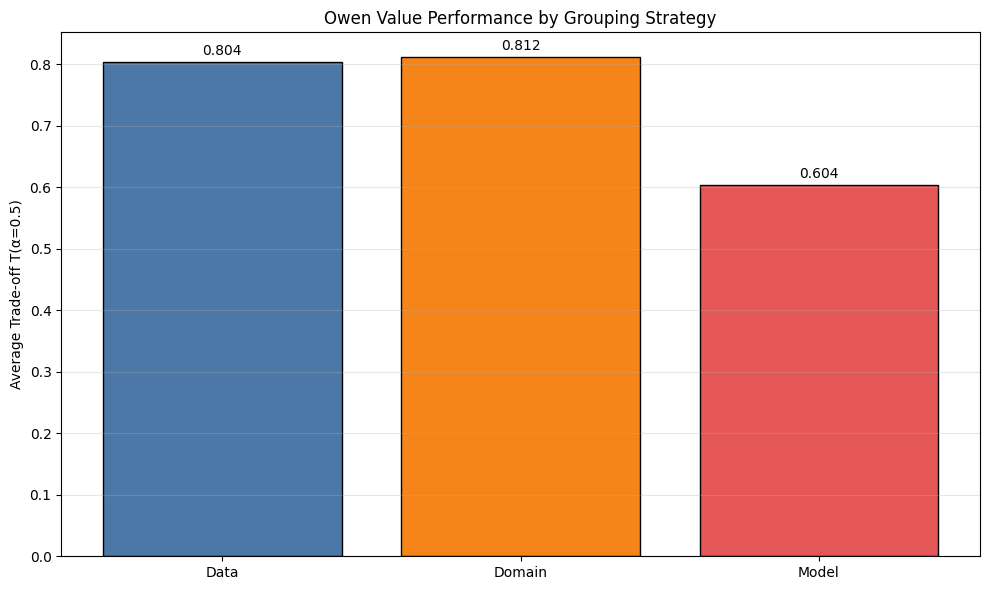

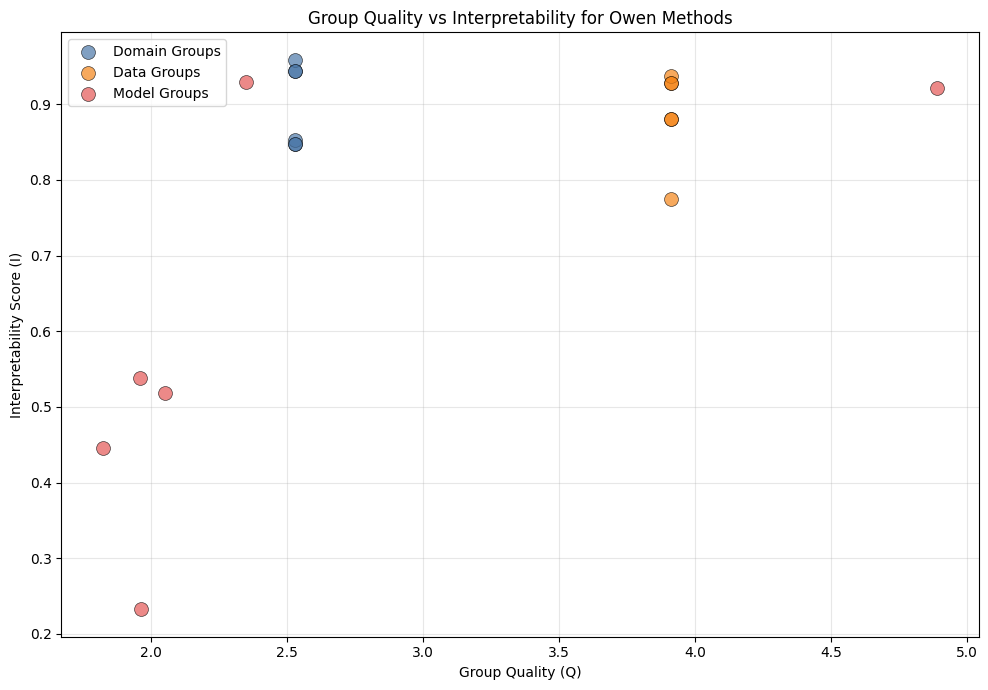

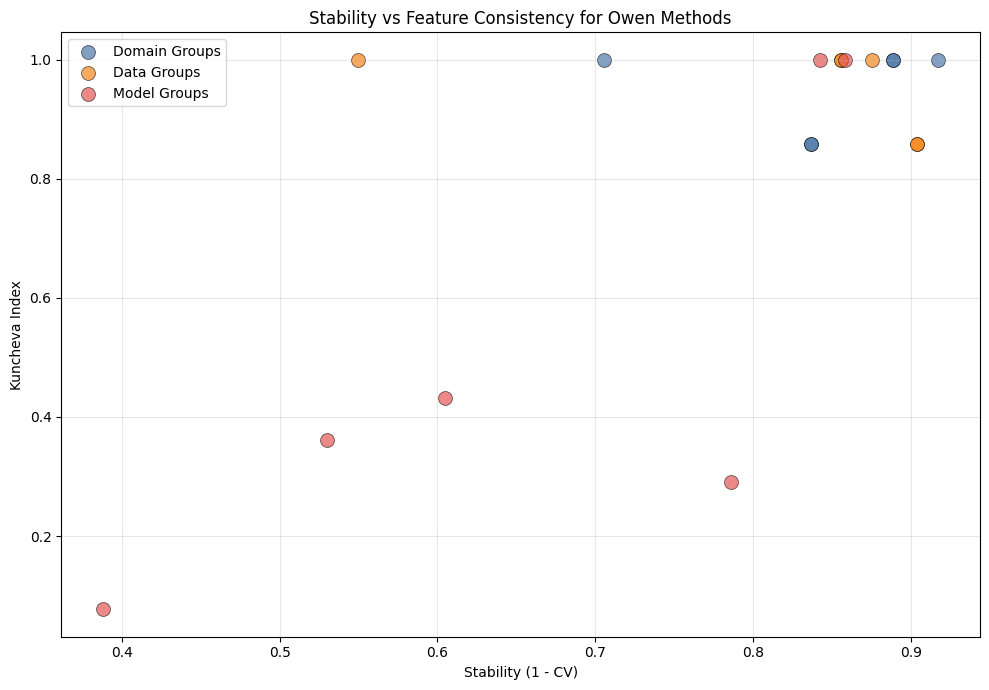

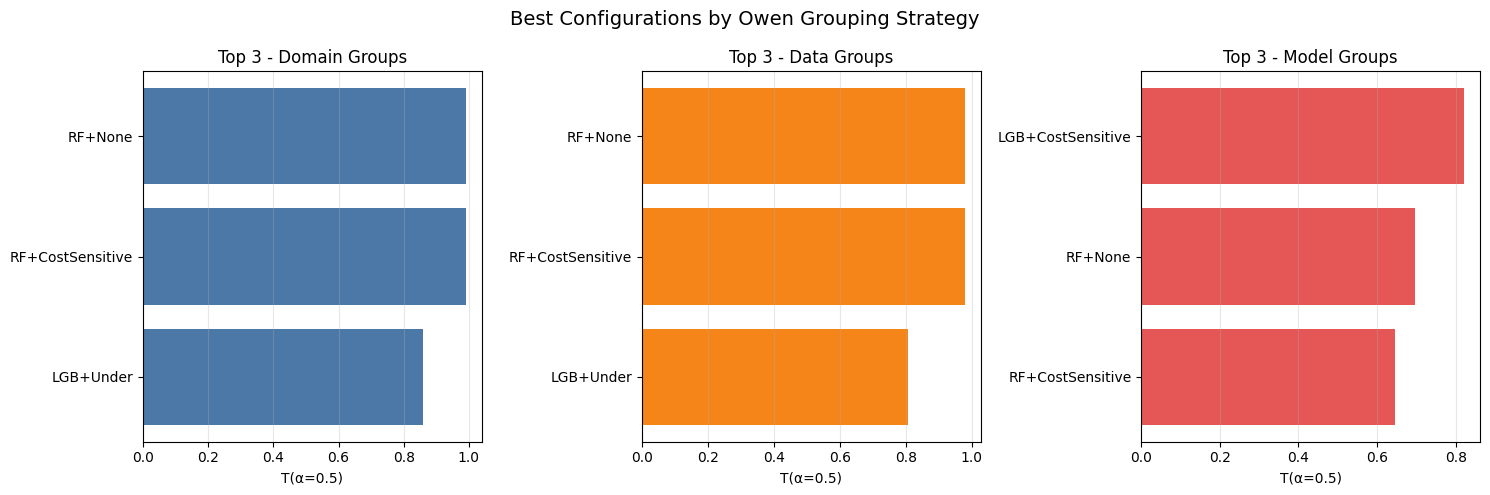


Visualizations saved:
  - owen_grouping_tradeoff.png
  - owen_q_vs_interpretability.png
  - owen_stability_vs_kuncheva.png
  - owen_best_configurations.png


In [16]:
# ============================================================
# 0. Restore original X and y
# ============================================================
X = df.drop('target', axis=1)
y = df['target']
print("Restored X and y shapes:", X.shape, y.shape)

# ============================================================
# 1. Helper functions for Owen groups (FIXED VERSION)
# ============================================================
from sklearn.cluster import AgglomerativeClustering

def get_feature_names_out(preprocessor):
    return preprocessor.get_feature_names_out()

# ---------- Domain-driven groups ----------
def build_domain_groups(fnames):
    groups = {
        "EmploymentIncome": [],
        "LoanCharacteristics": [],
        "Purpose": [],
        "AssetsCollateral": [],
        "Location": []
    }
    for i, name in enumerate(fnames):
        lname = name.lower()
        if any(k in lname for k in ["experience_c", "emp_length", "revenue", "dti_n", "fico_n"]):
            groups["EmploymentIncome"].append(i)
        if "loan_amnt" in lname:
            groups["LoanCharacteristics"].append(i)
        if "purpose" in lname:
            groups["Purpose"].append(i)
        if "home_ownership_n" in lname:
            groups["AssetsCollateral"].append(i)
        if "addr_state" in lname:
            groups["Location"].append(i)
    return {g: v for g, v in groups.items() if len(v) > 0}

# ---------- Data-driven groups ----------
def build_data_groups(X_proc, n_groups=6):
    try:
        # Clean X_proc
        X_proc = np.nan_to_num(X_proc, nan=0.0)

        # Compute correlation safely
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)

        # Handle NaN/Inf in correlation
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)

        # Ensure valid correlation values
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        # Ensure distance matrix is valid
        dist = np.clip(dist, 0.0, 2.0)

        # Check if we have enough features
        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)
        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Cluster_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"Warning: Data-driven grouping failed: {e}")
        # Return default groups
        n_features = X_proc.shape[1]
        default_groups = {"Default_Group": list(range(n_features))}
        return default_groups, np.eye(n_features)

# ---------- Model-driven groups ----------
def build_model_groups(shap_vals, n_groups=6):
    try:
        # Clean SHAP values
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)

        # Handle different dimensions
        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()

        # Transpose for correlation if needed
        if shap_vals.shape[0] < shap_vals.shape[1]:
            shap_vals = shap_vals.T

        # Ensure we have enough samples
        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            default_groups = {"Default_Group": list(range(n_features))}
            return default_groups, np.eye(n_features)

        # Compute correlation safely
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)

        # Handle NaN/Inf
        corr = np.nan_to_num(corr, nan=0.0, posinf=0.0, neginf=0.0)
        np.fill_diagonal(corr, 1.0)
        corr = np.clip(corr, -1.0, 1.0)

        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        # Adjust n_groups if needed
        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups,
            metric='precomputed',
            linkage='average'
        )
        labels = clustering.fit_predict(dist)
        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"SHAPGroup_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"Warning: Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        default_groups = {"Default_Group": list(range(n_features))}
        return default_groups, np.eye(n_features)

# ---------- Q metric ----------
def compute_Q(groups, dep):
    try:
        d = dep.shape[0]
        group_id = np.full(d, -1)
        for gid, (gname, feats) in enumerate(groups.items()):
            for f in feats:
                if f < d:
                    group_id[f] = gid

        within, across = [], []
        for i in range(d):
            for j in range(i+1, d):
                if group_id[i] == group_id[j] and group_id[i] != -1:
                    within.append(dep[i, j])
                elif group_id[i] != -1 and group_id[j] != -1:
                    across.append(dep[i, j])

        if len(within) == 0 or len(across) == 0:
            return 1.0

        within_mean = np.mean(within)
        across_mean = np.mean(across)

        if across_mean == 0:
            return 1.0 if within_mean == 0 else 10.0

        return float(within_mean / across_mean)
    except:
        return 1.0

# ---------- Owen redistribution ----------
def owen_from_shap(phi, groups):
    d = len(phi)
    out = np.zeros(d)
    for _, feats in groups.items():
        if len(feats) == 0:
            continue
        # Only consider valid indices
        valid_feats = [f for f in feats if f < d]
        if not valid_feats:
            continue

        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)
        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per
    return out

# ============================================================
# 2. Owen Groups Experiment (FIXED)
# ============================================================
print("\n" + "="*80)
print("RUNNING OWEN GROUPS EXPERIMENT (FIXED VERSION)")
print("="*80)

# Use faster sampling for efficiency
FAST_MODE = True
if FAST_MODE:
    SAMPLE_SIZE = 200
    BATCH_SIZE = 100
else:
    SAMPLE_SIZE = 500
    BATCH_SIZE = 200

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3 folds for speed
owen_records = []

# Process only top configurations for speed
top_configs = [
    ('RF', 'None'),
    ('RF', 'Under'),
    ('RF', 'CostSensitive'),
    ('LGB', 'None'),
    ('LGB', 'Under'),
    ('LGB', 'CostSensitive')
]

for mname, sname in top_configs:
    sampler = resamplers[sname]
    print(f"\nProcessing: {mname} + {sname}")

    aucs = []
    shap_vecs = []
    dom_vecs = []
    data_vecs = []
    mod_vecs = []

    Q_dom_list = []
    Q_data_list = []
    Q_mod_list = []

    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y), 1):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        steps = [('prep', preprocessor)]
        if sampler and sampler != 'cost':
            steps.append(('samp', sampler))
        steps.append(('clf', models[mname]))
        pipe = ImbPipeline(steps)

        # cost-sensitive
        if sname == 'CostSensitive':
            if mname == 'RF':
                pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
            elif mname == 'XGB':
                ratio = class_weight_dict[1] / class_weight_dict[0]
                pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
            elif mname == 'LGB':
                pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

        pipe.fit(X_tr, y_tr)

        auc = roc_auc_score(y_te, pipe.predict_proba(X_te)[:, 1])
        aucs.append(auc)
        print(f"  Fold {fold}: AUC = {auc:.4f}")

        # SHAP baseline on test (small sample for speed)
        X_te_sample = X_te.sample(n=min(SAMPLE_SIZE, len(X_te)), random_state=42+fold)
        try:
            shap_vals = get_shap_reliable(pipe, X_te_sample)
            phi = np.mean(shap_vals, axis=0)
            shap_vecs.append(phi)
        except:
            phi = np.zeros(preprocessor.transform(X_te_sample[:1]).shape[1])
            shap_vecs.append(phi)

        # Preprocessed train for grouping
        X_tr_proc = pipe.named_steps['prep'].transform(X_tr)
        fnames = get_feature_names_out(preprocessor)

        # ---- Domain groups ----
        dom_groups = build_domain_groups(fnames)
        try:
            with np.errstate(invalid='ignore'):
                corr_tr = np.abs(np.corrcoef(X_tr_proc.T))
            corr_tr = np.nan_to_num(corr_tr, nan=0.0)
            Q_dom_list.append(compute_Q(dom_groups, corr_tr))
        except:
            Q_dom_list.append(1.0)

        dom_vecs.append(owen_from_shap(phi, dom_groups))

        # ---- Data-driven groups ----
        try:
            data_groups, dep_data = build_data_groups(X_tr_proc)
            Q_data_list.append(compute_Q(data_groups, dep_data))
            data_vecs.append(owen_from_shap(phi, data_groups))
        except:
            Q_data_list.append(1.0)
            data_vecs.append(owen_from_shap(phi, {"Default": list(range(len(phi)))}))

        # ---- Model-driven groups (SHAP on train subset) ----
        try:
            # Use smaller sample for speed
            bg_idx = np.random.choice(len(X_tr), size=min(BATCH_SIZE, len(X_tr)), replace=False)
            shap_bg = get_shap_reliable(pipe, X_tr.iloc[bg_idx])

            # Clean SHAP values
            shap_bg = np.nan_to_num(shap_bg, nan=0.0)

            # Ensure 2D array
            if shap_bg.ndim == 1:
                shap_bg = shap_bg.reshape(1, -1)
            elif shap_bg.ndim == 3:
                shap_bg = shap_bg.mean(axis=2) if shap_bg.shape[2] > 1 else shap_bg[:, :, 0]

            mod_groups, dep_mod = build_model_groups(shap_bg)
            Q_mod_list.append(compute_Q(mod_groups, dep_mod))
            mod_vecs.append(owen_from_shap(phi, mod_groups))
        except Exception as e:
            print(f"    Model grouping failed: {e}")
            Q_mod_list.append(1.0)
            mod_vecs.append(owen_from_shap(phi, {"Default": list(range(len(phi)))}))

    # Wrap vectors for metrics
    def wrap(vlist):
        return [v.reshape(1, -1) for v in vlist]

    auc_mean = np.mean(aucs)

    # SHAP
    cv_s = stability_cv(wrap(shap_vecs))
    ku_s = kuncheva_index(wrap(shap_vecs))
    I_s = interpretability_score(cv_s, ku_s)

    # Domain
    cv_d = stability_cv(wrap(dom_vecs))
    ku_d = kuncheva_index(wrap(dom_vecs))
    I_d = interpretability_score(cv_d, ku_d)

    # Data
    cv_da = stability_cv(wrap(data_vecs))
    ku_da = kuncheva_index(wrap(data_vecs))
    I_da = interpretability_score(cv_da, ku_da)

    # Model
    cv_m = stability_cv(wrap(mod_vecs))
    ku_m = kuncheva_index(wrap(mod_vecs))
    I_m = interpretability_score(cv_m, ku_m)

    # Store records
    owen_records += [
        {
            'Model': mname, 'Sampler': sname,
            'Method': 'SHAP', 'Grouping': 'None',
            'AUC': auc_mean, 'CV': cv_s,
            'Stability': 1 - cv_s, 'Kuncheva': ku_s,
            'I': I_s, 'Q': np.nan
        },
        {
            'Model': mname, 'Sampler': sname,
            'Method': 'Owen', 'Grouping': 'Domain',
            'AUC': auc_mean, 'CV': cv_d,
            'Stability': 1 - cv_d, 'Kuncheva': ku_d,
            'I': I_d, 'Q': float(np.nanmean(Q_dom_list))
        },
        {
            'Model': mname, 'Sampler': sname,
            'Method': 'Owen', 'Grouping': 'Data',
            'AUC': auc_mean, 'CV': cv_da,
            'Stability': 1 - cv_da, 'Kuncheva': ku_da,
            'I': I_da, 'Q': float(np.nanmean(Q_data_list))
        },
        {
            'Model': mname, 'Sampler': sname,
            'Method': 'Owen', 'Grouping': 'Model',
            'AUC': auc_mean, 'CV': cv_m,
            'Stability': 1 - cv_m, 'Kuncheva': ku_m,
            'I': I_m, 'Q': float(np.nanmean(Q_mod_list))
        }
    ]

# ============================================================
# 3. Final results
# ============================================================
owen_groups_df = pd.DataFrame(owen_records)
owen_groups_df['T(α=0.5)'] = tradeoff_metric(owen_groups_df['AUC'], owen_groups_df['I'])

print("\n" + "="*80)
print("OWEN GROUPS RESULTS")
print("="*80)
print(owen_groups_df.round(4).to_string(index=False))

# Summary by grouping method
print("\n" + "="*80)
print("SUMMARY BY GROUPING METHOD")
print("="*80)
summary = owen_groups_df.groupby(['Method', 'Grouping']).agg({
    'AUC': 'mean',
    'Stability': 'mean',
    'Kuncheva': 'mean',
    'I': 'mean',
    'Q': 'mean',
    'T(α=0.5)': 'mean'
}).round(4).reset_index()
print(summary)

# Compare Owen groupings
print("\n" + "="*80)
print("COMPARISON OF OWEN GROUPING STRATEGIES")
print("="*80)
owen_only = owen_groups_df[owen_groups_df['Method'] == 'Owen']
for grouping in ['Domain', 'Data', 'Model']:
    subset = owen_only[owen_only['Grouping'] == grouping]
    print(f"\n{grouping} Grouping:")
    print(f"  Avg Q: {subset['Q'].mean():.4f}")
    print(f"  Avg I: {subset['I'].mean():.4f}")
    print(f"  Avg T(α=0.5): {subset['T(α=0.5)'].mean():.4f}")

# Correlation between Q and I for Owen methods
print("\n" + "="*80)
print("CORRELATION BETWEEN Q AND INTERPRETABILITY")
print("="*80)
for grouping in ['Domain', 'Data', 'Model']:
    subset = owen_only[owen_only['Grouping'] == grouping]
    if len(subset) > 1:
        from scipy import stats
        rho, p = stats.spearmanr(subset['Q'], subset['I'])
        print(f"{grouping} Groups: ρ = {rho:.4f}, p = {p:.4f}")

owen_groups_df.to_csv("lc_owen_groups_results.csv", index=False)
print("\nSaved: lc_owen_groups_results.csv")

# ============================================================
# 4. Visualization
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*80)
print("GENERATING VISUALIZATIONS")
print("="*80)

# 1. Trade-off by Grouping Strategy
plt.figure(figsize=(10, 6))
grouping_data = owen_groups_df[owen_groups_df['Method'] == 'Owen'].groupby('Grouping')['T(α=0.5)'].mean()
colors = ['#4C78A8', '#F58518', '#E45756']
bars = plt.bar(grouping_data.index, grouping_data.values, color=colors, edgecolor='black')
plt.bar_label(bars, fmt='%.3f', padding=3)
plt.ylabel("Average Trade-off T(α=0.5)")
plt.title("Owen Value Performance by Grouping Strategy")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('owen_grouping_tradeoff.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Q vs Interpretability
plt.figure(figsize=(10, 7))
colors = {'Domain': '#4C78A8', 'Data': '#F58518', 'Model': '#E45756'}
for grouping in ['Domain', 'Data', 'Model']:
    subset = owen_only[owen_only['Grouping'] == grouping]
    plt.scatter(subset['Q'], subset['I'], s=100, alpha=0.7,
                label=f'{grouping} Groups', color=colors[grouping],
                edgecolors='black', linewidth=0.5)
plt.xlabel("Group Quality (Q)")
plt.ylabel("Interpretability Score (I)")
plt.title("Group Quality vs Interpretability for Owen Methods")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('owen_q_vs_interpretability.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. Stability vs Kuncheva
plt.figure(figsize=(10, 7))
for grouping in ['Domain', 'Data', 'Model']:
    subset = owen_only[owen_only['Grouping'] == grouping]
    plt.scatter(subset['Stability'], subset['Kuncheva'], s=100, alpha=0.7,
                label=f'{grouping} Groups', color=colors[grouping],
                edgecolors='black', linewidth=0.5)
plt.xlabel("Stability (1 - CV)")
plt.ylabel("Kuncheva Index")
plt.title("Stability vs Feature Consistency for Owen Methods")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('owen_stability_vs_kuncheva.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Best configurations per grouping
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, grouping in enumerate(['Domain', 'Data', 'Model']):
    subset = owen_only[owen_only['Grouping'] == grouping]
    top3 = subset.nlargest(3, 'T(α=0.5)')
    labels = [f"{row.Model}+{row.Sampler}" for _, row in top3.iterrows()]
    axes[idx].barh(labels, top3['T(α=0.5)'].values, color=colors[grouping])

    axes[idx].set_title(f"Top 3 - {grouping} Groups")
    axes[idx].set_xlabel("T(α=0.5)")
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)
plt.suptitle("Best Configurations by Owen Grouping Strategy", fontsize=14)
plt.tight_layout()
plt.savefig('owen_best_configurations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualizations saved:")
print("  - owen_grouping_tradeoff.png")
print("  - owen_q_vs_interpretability.png")
print("  - owen_stability_vs_kuncheva.png")
print("  - owen_best_configurations.png")